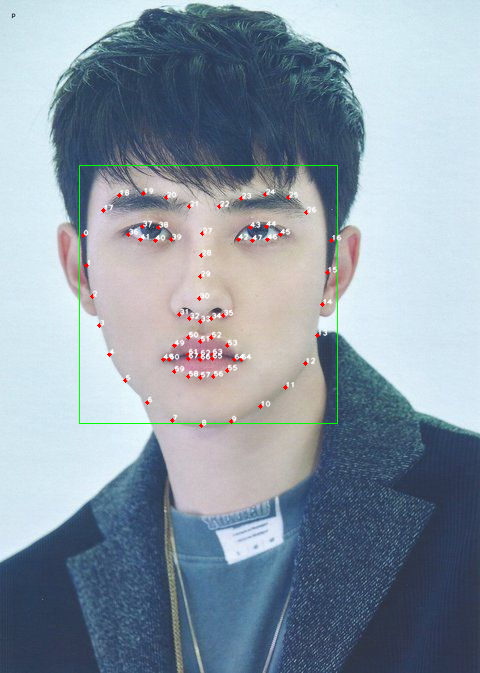

-1

In [2]:
import cv2
import dlib
from google.colab.patches import cv2_imshow

# 모듈생성
detect = dlib.get_frontal_face_detector()
predict = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/man_3.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 얼굴 검출
faces = detect(gray)
for rect in faces:
    # 얼굴 영역을 좌표로 변환
    x,y = rect.left(), rect.top()
    w,h = rect.right()-x, rect.bottom()-y
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)

    # 랜드마크 검출
    shape = predict(gray, rect)
    for i in range(68):
        # 좌표 추출
        part = shape.part(i)
        cv2.circle(img, (part.x, part.y), 2, (0, 0, 255), -1)
        cv2.putText(img, str(i), (part.x, part.y), cv2.FONT_HERSHEY_PLAIN, \
                                         0.5,(255,255,255), 1, cv2.LINE_AA)

cv2_imshow(img)
cv2.waitKey(0)

111


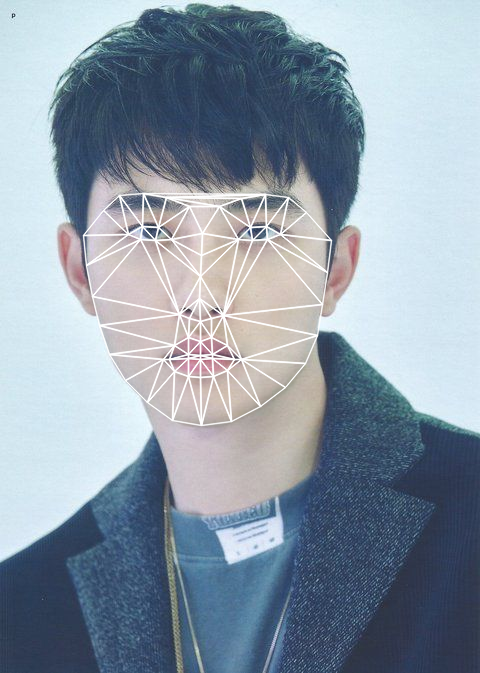

-1

In [3]:

import numpy as np


#모듈 생성
detect = dlib.get_frontal_face_detector()
predict = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/man_3.jpg")
h, w = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = faces = detect(gray)    # 얼굴 영역

points = []
for rect in rects:
    shape = predict(gray, rect)    # 랜드마크
    for i in range(68):
        part = shape.part(i)
        points.append((part.x, part.y))
        

x,y,w,h = cv2.boundingRect(np.float32(points))   # 들로네분할 객체 생성
subdiv2d = cv2.Subdiv2D((x,y,x+w,y+h))

subdiv2d.insert(points)    # 좌표
triangleList = subdiv2d.getTriangleList()

# 들로네 삼각형
h, w = img.shape[:2]
cnt = 0
for t in triangleList :
    pts = t.reshape(-1,2).astype(np.int32)
    if (pts < 0).sum() or (pts[:, 0] > w).sum() or (pts[:, 1] > h).sum():   # 이미지 영역 벗어나는 것 제외(음수)
        print(pts) 
        continue
    cv2.polylines(img, [pts], True, (255, 255,255), 1, cv2.LINE_AA)
    cnt+=1
print(cnt)


cv2_imshow(img)
cv2.waitKey(0)

In [4]:
import cv2
import numpy as np
import dlib
import sys

#모듈 생성
detect = dlib.get_frontal_face_detector()
predict = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

# 랜드마크 좌표 반환 함수 
def getPoints(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detect(gray)
    points = []
    for rect in rects:
        shape = predict(gray, rect)
        for i in range(68):
            part = shape.part(i)
            points.append((part.x, part.y))
    return points    

# 들로네 삼각형 반환 함수
def getTriangles(img, points):
    w,h = img2.shape[:2]
    subdiv = cv2.Subdiv2D((0,0,w,h));
    subdiv.insert(points) 
    triangleList = subdiv.getTriangleList();
    triangles = []
    for t in triangleList:        
        pt = t.reshape(-1,2)
        if not (pt < 0).sum() and not (pt[:, 0] > w).sum() \
                              and not (pt[:, 1] > h).sum(): 
            indice = []
            for i in range(0, 3):
                for j in range(0, len(points)):                    
                    if(abs(pt[i][0] - points[j][0]) < 1.0 \
                        and abs(pt[i][1] - points[j][1]) < 1.0):
                        indice.append(j)    
            if len(indice) == 3:                                                
                triangles.append(indice)
    return triangles

# 삼각형 어핀 변환 함수
def warpTriangle(img1, img2, pts1, pts2):
    x1,y1,w1,h1 = cv2.boundingRect(np.float32([pts1]))
    x2,y2,w2,h2 = cv2.boundingRect(np.float32([pts2]))
    
    roi1 = img1[y1:y1+h1, x1:x1+w1]
    roi2 = img2[y2:y2+h2, x2:x2+w2]
    
    offset1 = np.zeros((3,2), dtype=np.float32)
    offset2 = np.zeros((3,2), dtype=np.float32)
    for i in range(3):
        offset1[i][0], offset1[i][1] = pts1[i][0]-x1, pts1[i][1]-y1
        offset2[i][0], offset2[i][1] = pts2[i][0]-x2, pts2[i][1]-y2
    
    mtrx = cv2.getAffineTransform(offset1, offset2)
    warped = cv2.warpAffine( roi1, mtrx, (w2, h2), None, \
                        cv2.INTER_LINEAR, cv2.BORDER_REFLECT_101 )
    
    mask = np.zeros((h2, w2), dtype = np.uint8)
    cv2.fillConvexPoly(mask, np.int32(offset2), (255))
    
    warped_masked = cv2.bitwise_and(warped, warped, mask=mask)
    roi2_masked = cv2.bitwise_and(roi2, roi2, mask=cv2.bitwise_not(mask))
    roi2_masked = roi2_masked + warped_masked
    img2[y2:y2+h2, x2:x2+w2] = roi2_masked

if __name__ == '__main__' :
    img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/man_3.jpg')
    img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/woman_1.jpg') # 이미지 읽기
    cv2_imshow(img1)
    cv2_imshow(img2)
    img_draw = img2.copy()
    points1 = getPoints(img1)
    points2 = getPoints(img2)     # 랜드마크 좌표 반환 함수 실행
    hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)     # 랜드마크 좌표로 볼록 선체 구하기
    hull1 = [points1[int(idx)] for idx in hullIndex]
    hull2 = [points2[int(idx)] for idx in hullIndex]
    triangles = getTriangles(img2, hull2)    # 들로네 삼각형 반환 함수 실행
    
    for i in range(0, len(triangles)):       # 삼각형 어핀 변환 실행
        t1 = [hull1[triangles[i][j]] for j in range(3)]
        t2 = [hull2[triangles[i][j]] for j in range(3)]
        warpTriangle(img1, img_draw, t1, t2)

    mask = np.zeros(img2.shape, dtype = img2.dtype)       # 얼굴 합성
    cv2.fillConvexPoly(mask, np.int32(hull2), (255, 255, 255))
    r = cv2.boundingRect(np.float32([hull2]))    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    output = cv2.seamlessClone(np.uint8(img_draw), img2, mask, center, \
                                cv2.MIXED_CLONE)
    
    
    cv2_imshow(output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.